Using torch's dataset and dataloader modules

In [91]:
# imports 
import numpy as np
import pandas as pd
import os
import zipfile
import torch
from torch.nn import Module
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [194]:
# looking at the contents of the zipfile

zf = zipfile.ZipFile('4drtyfjtfy-1.zip', 'r')
print(zf.namelist())
zf.extractall()

['dataset2.zip']


In [195]:
# there is nother zipfile inside the previous one

zf2 = zipfile.ZipFile('dataset2.zip', 'r')
zf2.extractall()

In [2]:
# now we have a folder name ``dataset2``
path = 'dataset2/'
data = os.listdir(path=path)
# no of images in the dataset
len(data)

1125

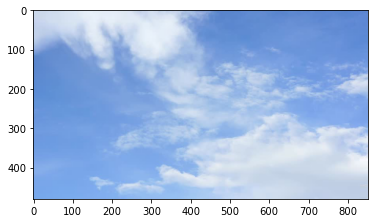

In [3]:
# inspecting one image
img = Image.open(os.path.join(path, data[0]))
plt.imshow(img)
plt.show()

In [4]:
# compiling images 
images = [(Image.open(os.path.join(path, image))) for image in data]

In [93]:
# compiling images into a pandas dataframe for easy idexing
# image_series = pd.Series(images)
# image_series.head()

(480, 852, 3) (413, 620, 3) (178, 283, 3) (400, 720, 3) 

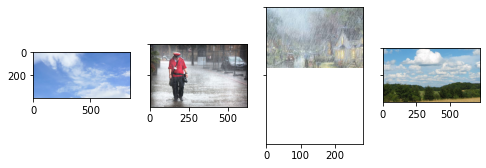

In [7]:
## let's look at a few images
# images come in different sizes

fig, ax = plt.subplots(1,4, sharey=True, figsize=(8,10))

for i in range(4):
    # shape of images (we have different size images)
    print(np.array(images[i]).shape, end=" ")
    ax[i].imshow(images[i])

In [8]:
# Let's look at the images and see if the match the expect "RGB" channels i.e, they have three color channels
# we will print the shape of the sample and remove it from the data
# we have to remove the labels as well

for idx, (image, label) in enumerate(zip(images,data)):
    array = np.array(image)
    if len(array.shape) != 3:
        data.remove(label)
        images.remove(image)
        print(array.shape, idx)
    elif array.shape[2] != 3:
        data.remove(label)
        images.remove(image)
        print(array.shape, idx)

(288, 384) 159
(453, 640) 783
(254, 600) 853
(177, 284, 4) 1019
(360, 480) 1101


In [9]:
## double check to see if we removed all images
# that have channels other than 3

for idx, (image, label) in enumerate(zip(images, data)):
    array = np.array(image)
    if len(array.shape) != 3:
        print(array.shape, idx)
    elif array.shape[2] != 3:
        print(array.shape, idx)
print("Seems good to go")

Seems good to go


In [10]:
# print the shapes of labels and images
print(len(images))
print(len(data))

1120
1120


In [11]:
# using regular expression to get the labels 
import re
# pattern with first set of alphabets which are the labels
word_pattern = r'[a-zA-Z]+'
extracted_word = re.match(word_pattern, data[4])
extracted_word.group()

'sunrise'

cloudy


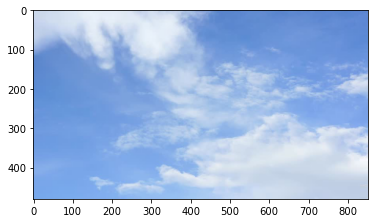

In [12]:
# creating the labels
labels = [re.match(r"[a-zA-Z]+", label).group() for label in data]
# checking to see if we have the images and labels correctly compiled
for image, label in zip(images, labels):
    plt.imshow(image)
    print(label)
    break

cloudy              rain              rain              cloudy              

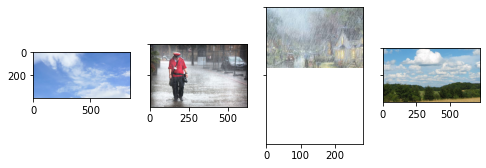

In [13]:
## let's look at a few images and their labels

fig, ax = plt.subplots(1,4, sharey=True, figsize=(8,10))

for i in range(4):
    print(labels[i], end="              ")
    ax[i].imshow(images[i])
#     ax[i].title(f"{labels[i]}")
    

In [14]:
# let's look at the distribution of labels
pd_labels = pd.Series(labels)
pd_labels.value_counts()

sunrise    357
cloudy     298
shine      251
rain       214
dtype: int64

In [15]:
# creating a string to integer mapping 
label_to_int = {
    'sunrise': 0,
    'cloudy' : 1,
    'shine'  : 2,
      'rain' : 3
}

integer_labels = pd_labels.map(label_to_int)
integer_labels[:5]

0    1
1    3
2    3
3    1
4    0
dtype: int64

In [16]:
## integer to label mapping 

int_to_label = dict({(v, k) for k, v in label_to_int.items()})
int_to_label.items()

dict_items([(2, 'shine'), (0, 'sunrise'), (1, 'cloudy'), (3, 'rain')])

In [17]:
# Check to see if the mapping worked
label_to_int.items()

dict_items([('sunrise', 0), ('cloudy', 1), ('shine', 2), ('rain', 3)])

In [18]:
# splitting the dataset
np.random.seed(12)

indices = list(range(len(images)))
# shuffle the indices
np.random.shuffle(indices)
# split the indices for test, train and valid
test_size = int(np.floor(0.1 * len(images)))
valid_size = int(np.floor(0.1 * len(images)))

X_valid, X_test, X_train = images[: valid_size], images[valid_size: valid_size + test_size], images[valid_size + test_size : ]
y_valid, y_test, y_train = integer_labels[: valid_size], integer_labels[valid_size: valid_size + test_size], integer_labels[valid_size + test_size : ]

In [19]:
## checking the sizes of the new datasets
print(len(X_valid), len(X_test), len(X_train))
print(len(y_valid), len(y_test), len(y_train))

112 112 896
112 112 896


0                 2                 1                 1                 

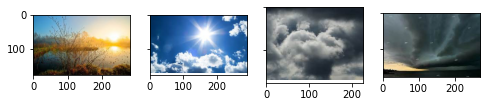

In [20]:
## visualizing the images again

fig, ax = plt.subplots(1,4, sharey=True, figsize=(8,10))

for idx, (image, label) in enumerate(zip(X_train, y_train)):
    print(label, end="                 ")
    ax[idx].imshow(image)
    if idx == 3:
        break

In [18]:
# # Splitting the dataset 

# random_seed = 123
# test_split = .1
# valid_split = .1
# batch_size = 16
# shuffle_dataset = True

# # creating indices for train, valid and test set
# dataset_size = image_series.shape[0]
# indices = list(range(image_series.shape[0]))

# # validation spit
# valid_ = int(np.floor(valid_split * dataset_size))
# test_ = int(np.floor(test_split * dataset_size))

# if shuffle_dataset:
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)

# # splitting the dataset
# test, valid, train = indices[: test_], indices[test_ : test_ + valid_], indices[test_ + valid_ :]
# len(test), len(valid), len(train)

(112, 112, 901)

In [19]:
# ## splitting the dataseries into train, test and valid sets
# X_train, X_valid, X_test = image_series[train], image_series[valid], image_series[test]

# y_train, y_valid, y_test = integer_labels[train], integer_labels[valid], integer_labels[test]

In [20]:
# # sanity check to see if have expected splits
# X_train.shape, X_valid.shape, X_test.shape

((901,), (112,), (112,))

In [66]:
# custom dataset

class Weather_Data(Dataset):
    """Custom dataset"""
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):

#         img_tensor = [(torch.tensor(np.array(image))) for image in self.images]
        label_tensor = [torch.tensor(label) for label in self.labels]
        
        X = self.images[idx]
        if self.transform is not None:
            X = self.transform(X)
#         X = img_tensor[idx]
        y = label_tensor[idx]
        return X, y

In [67]:
# creating transfroms for training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# creating transforms for evaluation set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [153]:
## Creating the datasets 
batch_size = 32

train_dataset = Weather_Data(X_train, y_train, transform=train_transform)

valid_dataset = Weather_Data(X_valid, y_valid, transform=test_transform)

test_dataset = Weather_Data(X_test, y_test, transform=test_transform)

## Creating the dataloader

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,)

valid_loader = DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=True,)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [69]:
## iterating to see if the dataset behaves as expected
for image, label in train_dataset:
    print("Train dataset:", image.size(), label)
    break
    
for image, label in valid_dataset:
    print("Valid dataset:", image.size(), label)
    break
    
for image, label in test_dataset:
    print("Test dataset:", image.size(), label)
    break

## iterating through the dataloader
for batch, data in enumerate(train_loader):
    print("Train loader:", batch, data[0].size(), data[1].size())
    break
    
for batch, data in enumerate(valid_loader):
    print("Valid Loader:", batch, data[0].size(), data[1].size())
    break
    
for batch, data in enumerate(test_loader):
    print("Test Loader:", batch, data[0].size(), data[1].size())
    break

Train dataset: torch.Size([3, 224, 224]) tensor(0)
Valid dataset: torch.Size([3, 224, 224]) tensor(1)
Test dataset: torch.Size([3, 224, 224]) tensor(2)
Train loader: 0 torch.Size([16, 3, 224, 224]) torch.Size([16])
Valid Loader: 0 torch.Size([16, 3, 224, 224]) torch.Size([16])
Test Loader: 0 torch.Size([16, 3, 224, 224]) torch.Size([16])


In [110]:
## building a simple CNN model

class SimpleCnn(Module):
    """Simple Convolutional Net"""
    
    def __init__(self, num_classes, in_channels,):
        super().__init__()
        
        self.num_classes = num_classes
        self.in_channels = in_channels
        
        self.conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=self.in_channels,
                      out_channels=6*self.in_channels,
                      kernel_size=5,
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6*self.in_channels,
                      out_channels=16*self.in_channels,
                      kernel_size=5,
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=16*self.in_channels,
                     out_channels=32*self.in_channels,
                     kernel_size=5,
                     padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*28*28*self.in_channels, 120*self.in_channels),
            nn.ReLU(),
            nn.Linear(120*self.in_channels, 60*self.in_channels),
            nn.ReLU(),
            nn.Linear(60*self.in_channels, self.num_classes))
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [154]:
## Parameters

RANDOM_SEED = 123
NUM_EPOCHS = 25
LR = 1e-3

# architecture
NUM_CLASSES = 4
NUM_FEATURES = 224*224
IN_CHANNELS = 3

# device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = 'cpu'


In [155]:
## instantiating the model 

model = SimpleCnn(num_classes=NUM_CLASSES, in_channels=IN_CHANNELS)
model.to(DEVICE)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR,)

In [ ]:
## compute accuracy of the model

def compute_accuracy(model, data_loader, device):
    """Calculates the accuracy of the provided model 
    and the data loader"""
    
    model.eval()
    with torch.set_grad_enabled(False):
        correct_pred, num_examples = 0, 0
        for i, (features, labels) in enumerate(tqdm(data_loader)):

            model.eval()
            with torch.set_grad_enabled(False):

            model = model.to(device)

            features = features.to(device)
            labels = labels.to(device)

            logits, probas = model(features)
            _, predicted_labels = torch.max(probas, dim=1)
            num_examples += labels.size(0)
        correct_pred += (predicted_labels == labels).sum()
    return correct_pred.float() / num_examples * 100

In [ ]:
## compute validation loss 

def validation_loss(model, loader, device):
    """Returns average loss
    of the model and dataloader 
    """
    
    model.eval()
    with torch.set_grad_enabled(False):
    loss = []
        for batch_idx, (features, labels) in enumerate(tqdm(loader)):

            model.eval()
            with torch.set_grad_enabled(False):

            model = model.to(device)
            features = features.to(device)
            labels = labels.to(device)

            logits, probas = model(features)
            cost = F.cross_entropy(logits, labels)

            loss.append(cost)
    return loss 

In [159]:
## Training the model 


train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(NUM_EPOCHS):
    # start time 
    start_time = time()
    model.train()
    
    for batch_idx, (features, labels) in enumerate(tqdm(train_loader)):
        
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # forward and backward pass 
        logits, probas = model(features)
        loss = F.cross_entropy(logits, labels)
        
        # collecting training loss 
        train_loss.append(loss)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        # logging the model activity
        
        if not batch_idx % 25:
            print(f"Epoch: {epoch:03d}/{NUM_EPOCHS:03d} | Batch: {batch_idx:03d}/{len(train_loader):03d} | Loss: {loss:.4f}")
        
    model.eval()
    with torch.set_grad_enabled(False):
        
        # collecting validation loss
        val_loss += validation_loss(model, valid_loader, DEVICE)
        
        # accuracy on validation set
        val_accuracy.append(compute_accuracy(model, valid_loader, DEVICE))
        
        # accuracy on training set
        train_accuracy.append(compute_accuracy(model, train_loader, DEVICE))

        print(f"Epoch: {epoch:03d}/{NUM_EPOCHS:03d} | Valid Accuracy: {compute_accuracy(model, valid_loader, DEVICE):.2f}%"
              f"| Train Accuracy: {compute_accuracy(model, train_loader, DEVICE):.2f}%")
    
    print(f"Time elapsed: {((time() - start_time) / 60):.2f} min")
    
print(f"Total time elapsed: {((time() - start_time) / 60):.2f} min")


  4%|▎         | 1/28 [00:06<02:59,  6.65s/it]

Epoch: 000/025 | Batch: 000/028 | Loss: 1.3899


 93%|█████████▎| 26/28 [02:53<00:11,  5.91s/it]

Epoch: 000/025 | Batch: 025/028 | Loss: 0.5136


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 000/025 | Valid Accuracy: 71.43%| Train Accuracy: 76.23%
Time elapsed: 5.60 min


  4%|▎         | 1/28 [00:06<03:08,  6.99s/it]

Epoch: 001/025 | Batch: 000/028 | Loss: 0.9353


 93%|█████████▎| 26/28 [02:04<00:09,  4.64s/it]

Epoch: 001/025 | Batch: 025/028 | Loss: 0.4010


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 001/025 | Valid Accuracy: 80.36%| Train Accuracy: 85.71%
Time elapsed: 4.26 min


  4%|▎         | 1/28 [00:05<02:31,  5.61s/it]

Epoch: 002/025 | Batch: 000/028 | Loss: 0.3770


 93%|█████████▎| 26/28 [02:04<00:09,  4.80s/it]

Epoch: 002/025 | Batch: 025/028 | Loss: 0.5769


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 002/025 | Valid Accuracy: 83.04%| Train Accuracy: 83.93%
Time elapsed: 5.81 min


  4%|▎         | 1/28 [00:17<07:41, 17.10s/it]

Epoch: 003/025 | Batch: 000/028 | Loss: 0.5541


 93%|█████████▎| 26/28 [05:36<00:16,  8.48s/it]

Epoch: 003/025 | Batch: 025/028 | Loss: 0.2591


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 003/025 | Valid Accuracy: 83.04%| Train Accuracy: 90.40%
Time elapsed: 9.70 min


  4%|▎         | 1/28 [00:12<05:48, 12.90s/it]

Epoch: 004/025 | Batch: 000/028 | Loss: 0.4247


 93%|█████████▎| 26/28 [04:46<00:21, 10.62s/it]

Epoch: 004/025 | Batch: 025/028 | Loss: 0.1214


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 004/025 | Valid Accuracy: 91.07%| Train Accuracy: 90.85%
Time elapsed: 10.49 min


  4%|▎         | 1/28 [00:18<08:17, 18.44s/it]

Epoch: 005/025 | Batch: 000/028 | Loss: 0.5195


 93%|█████████▎| 26/28 [07:54<00:20, 10.12s/it]

Epoch: 005/025 | Batch: 025/028 | Loss: 0.5445


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 005/025 | Valid Accuracy: 76.79%| Train Accuracy: 79.58%
Time elapsed: 12.23 min


  4%|▎         | 1/28 [00:06<02:47,  6.19s/it]

Epoch: 006/025 | Batch: 000/028 | Loss: 0.4918


 93%|█████████▎| 26/28 [02:44<00:11,  5.57s/it]

Epoch: 006/025 | Batch: 025/028 | Loss: 0.3574


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 006/025 | Valid Accuracy: 84.82%| Train Accuracy: 92.41%
Time elapsed: 7.05 min


  4%|▎         | 1/28 [00:11<05:19, 11.84s/it]

Epoch: 007/025 | Batch: 000/028 | Loss: 0.1832


 93%|█████████▎| 26/28 [04:29<00:18,  9.34s/it]

Epoch: 007/025 | Batch: 025/028 | Loss: 0.5154


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 007/025 | Valid Accuracy: 75.89%| Train Accuracy: 86.27%
Time elapsed: 8.43 min


  4%|▎         | 1/28 [00:07<03:23,  7.52s/it]

Epoch: 008/025 | Batch: 000/028 | Loss: 0.2075


 93%|█████████▎| 26/28 [02:49<00:12,  6.10s/it]

Epoch: 008/025 | Batch: 025/028 | Loss: 0.1853


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 008/025 | Valid Accuracy: 77.68%| Train Accuracy: 89.84%
Time elapsed: 5.23 min


  4%|▎         | 1/28 [00:06<02:55,  6.49s/it]

Epoch: 009/025 | Batch: 000/028 | Loss: 0.2941


 93%|█████████▎| 26/28 [02:14<00:09,  4.98s/it]

Epoch: 009/025 | Batch: 025/028 | Loss: 0.0624


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 009/025 | Valid Accuracy: 88.39%| Train Accuracy: 95.09%
Time elapsed: 8.39 min


  4%|▎         | 1/28 [00:21<09:36, 21.35s/it]

Epoch: 010/025 | Batch: 000/028 | Loss: 0.2035


 93%|█████████▎| 26/28 [06:43<00:30, 15.07s/it]

Epoch: 010/025 | Batch: 025/028 | Loss: 0.1381


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 010/025 | Valid Accuracy: 90.18%| Train Accuracy: 94.64%
Time elapsed: 15.53 min


  4%|▎         | 1/28 [00:22<10:20, 22.98s/it]

Epoch: 011/025 | Batch: 000/028 | Loss: 0.0436


 93%|█████████▎| 26/28 [04:25<00:10,  5.33s/it]

Epoch: 011/025 | Batch: 025/028 | Loss: 0.1110


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 011/025 | Valid Accuracy: 85.71%| Train Accuracy: 93.19%
Time elapsed: 6.89 min


  4%|▎         | 1/28 [00:06<02:55,  6.50s/it]

Epoch: 012/025 | Batch: 000/028 | Loss: 0.3031


 93%|█████████▎| 26/28 [02:22<00:12,  6.03s/it]

Epoch: 012/025 | Batch: 025/028 | Loss: 0.1889


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 012/025 | Valid Accuracy: 91.07%| Train Accuracy: 96.65%
Time elapsed: 5.01 min


  4%|▎         | 1/28 [00:08<03:40,  8.17s/it]

Epoch: 013/025 | Batch: 000/028 | Loss: 0.1126


 93%|█████████▎| 26/28 [02:32<00:10,  5.15s/it]

Epoch: 013/025 | Batch: 025/028 | Loss: 0.1087


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 013/025 | Valid Accuracy: 86.61%| Train Accuracy: 94.42%
Time elapsed: 5.11 min


  4%|▎         | 1/28 [00:07<03:33,  7.92s/it]

Epoch: 014/025 | Batch: 000/028 | Loss: 0.0898


 93%|█████████▎| 26/28 [02:28<00:10,  5.01s/it]

Epoch: 014/025 | Batch: 025/028 | Loss: 0.0120


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 014/025 | Valid Accuracy: 89.29%| Train Accuracy: 95.65%
Time elapsed: 5.53 min


  4%|▎         | 1/28 [00:10<04:44, 10.52s/it]

Epoch: 015/025 | Batch: 000/028 | Loss: 0.1707


 93%|█████████▎| 26/28 [02:34<00:09,  4.89s/it]

Epoch: 015/025 | Batch: 025/028 | Loss: 0.1206


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 015/025 | Valid Accuracy: 88.39%| Train Accuracy: 97.21%
Time elapsed: 4.76 min


  4%|▎         | 1/28 [00:06<02:53,  6.44s/it]

Epoch: 016/025 | Batch: 000/028 | Loss: 0.1276


 93%|█████████▎| 26/28 [02:03<00:09,  4.80s/it]

Epoch: 016/025 | Batch: 025/028 | Loss: 0.2518


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 016/025 | Valid Accuracy: 85.71%| Train Accuracy: 96.65%
Time elapsed: 4.22 min


  4%|▎         | 1/28 [00:06<03:00,  6.67s/it]

Epoch: 017/025 | Batch: 000/028 | Loss: 0.1179


 93%|█████████▎| 26/28 [02:39<00:11,  5.63s/it]

Epoch: 017/025 | Batch: 025/028 | Loss: 0.0767


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 017/025 | Valid Accuracy: 89.29%| Train Accuracy: 98.10%
Time elapsed: 5.04 min


  4%|▎         | 1/28 [00:06<03:05,  6.89s/it]

Epoch: 018/025 | Batch: 000/028 | Loss: 0.0170


 93%|█████████▎| 26/28 [02:12<00:09,  4.99s/it]

Epoch: 018/025 | Batch: 025/028 | Loss: 0.1742


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 018/025 | Valid Accuracy: 91.07%| Train Accuracy: 97.10%
Time elapsed: 4.50 min


  4%|▎         | 1/28 [00:05<02:40,  5.96s/it]

Epoch: 019/025 | Batch: 000/028 | Loss: 0.0366


 93%|█████████▎| 26/28 [02:00<00:09,  4.65s/it]

Epoch: 019/025 | Batch: 025/028 | Loss: 0.0412


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 019/025 | Valid Accuracy: 89.29%| Train Accuracy: 98.66%
Time elapsed: 4.14 min


  4%|▎         | 1/28 [00:05<02:27,  5.47s/it]

Epoch: 020/025 | Batch: 000/028 | Loss: 0.0432


 93%|█████████▎| 26/28 [02:03<00:09,  4.75s/it]

Epoch: 020/025 | Batch: 025/028 | Loss: 0.1866


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 020/025 | Valid Accuracy: 84.82%| Train Accuracy: 92.08%
Time elapsed: 4.20 min


  4%|▎         | 1/28 [00:05<02:29,  5.53s/it]

Epoch: 021/025 | Batch: 000/028 | Loss: 0.3991


 93%|█████████▎| 26/28 [02:04<00:09,  4.65s/it]

Epoch: 021/025 | Batch: 025/028 | Loss: 0.2298


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 021/025 | Valid Accuracy: 83.93%| Train Accuracy: 93.53%
Time elapsed: 4.20 min


  4%|▎         | 1/28 [00:05<02:26,  5.41s/it]

Epoch: 022/025 | Batch: 000/028 | Loss: 0.1743


 93%|█████████▎| 26/28 [02:03<00:09,  4.83s/it]

Epoch: 022/025 | Batch: 025/028 | Loss: 0.1291


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 022/025 | Valid Accuracy: 84.82%| Train Accuracy: 94.75%
Time elapsed: 4.25 min


  4%|▎         | 1/28 [00:05<02:37,  5.84s/it]

Epoch: 023/025 | Batch: 000/028 | Loss: 0.1450


 93%|█████████▎| 26/28 [02:04<00:09,  4.83s/it]

Epoch: 023/025 | Batch: 025/028 | Loss: 0.0549


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 023/025 | Valid Accuracy: 91.96%| Train Accuracy: 99.00%
Time elapsed: 4.21 min


  4%|▎         | 1/28 [00:05<02:37,  5.82s/it]

Epoch: 024/025 | Batch: 000/028 | Loss: 0.0128


 93%|█████████▎| 26/28 [02:35<00:12,  6.09s/it]

Epoch: 024/025 | Batch: 025/028 | Loss: 0.0599


100%|██████████| 28/28 [01:04<00:00,  2.31s/it]

Epoch: 024/025 | Valid Accuracy: 90.18%| Train Accuracy: 98.55%
Time elapsed: 5.27 min
Total time elapsed: 5.27 min


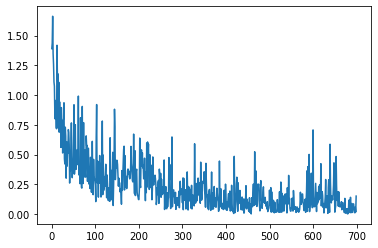

In [161]:
# plotting the training loss

plt.plot(train_loss)
plt.plot(val_loss[0] + val_loss[1])

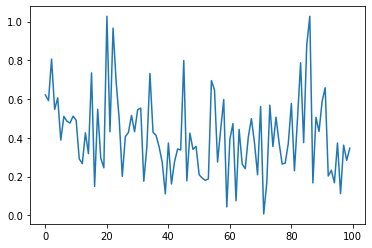

In [163]:
# plotting the validation loss

plt.plot(val_loss)

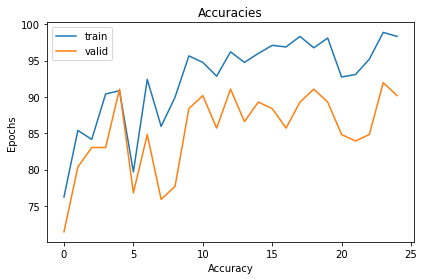

In [164]:
# plotting accuracies

plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='valid')
plt.legend()
plt.title("Accuracies")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.tight_layout()
plt.show()

torch.Size([3, 224, 224]) tensor(2)
True values:  tensor([2, 2, 2, 1, 3, 1, 0, 2, 3, 3])
Pred values:  tensor([2, 2, 2, 1, 1, 1, 1, 2, 1, 1])
Probabilities:  tensor([0.9894, 0.8465, 0.9598, 0.9992, 0.8157, 0.9942, 0.7011, 0.8722, 0.9757,
        0.9757])


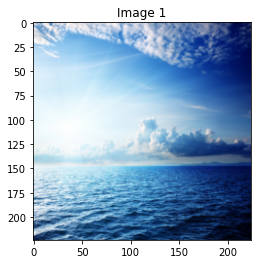

In [191]:
## let's look at predictions

for batch_id, (images, labels) in enumerate(test_loader):
    
    with torch.set_grad_enabled(False):
    
        print(images[0].size(), labels[0])
        sample_images = images[0:10]

        _, probas = model(sample_images)
        probas, indices  = torch.max(probas, dim=1)
        print("True values: ", labels[:10])
        print("Pred values: ", indices)
        print("Probabilities: ", probas)
        
        plt.imshow(images[0].permute(1,2,0))
        plt.title("Image 1")
        break

In [186]:
label_to_int

{'sunrise': 0, 'cloudy': 1, 'shine': 2, 'rain': 3}